In [1]:

import random
from data_loader import SingleEventSyntheticDataLoader
from hierarchical import util
from hierarchical.helper import format_hierarchical_hyperparams
from mensa.model import MENSA
import numpy as np
import pandas as pd
import config as cfg
from sota_models import DeepSurv, make_deephit_single, make_dsm_model
import torch
from utility.config import load_config
from utility.data import calculate_layer_size_hierarch, dotdict, format_hierarchical_data_cr
from utility.mtlr import mtlr
from utility.survival import convert_to_structured, make_time_bins

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'font.size': 16.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

dtype = torch.float64
torch.set_default_dtype(dtype)

device = device = torch.device('cpu')

def rename_model_names(df):
    model_name_mapping = {
        'deepsurv': 'DeepSurv',
        'deephit': 'DeepHit',
        'mtlr': 'MTLR',
        'dsm': 'DSM',
        'hierarch': "Hierarch.",
        'mensa': 'MENSA (Ours)',
    }
    df['ModelName'] = df['ModelName'].replace(model_name_mapping)
    return df

model_names = ["deepsurv", "deephit", "mtlr", "dsm" , "hierarch", "mensa"]

# Load results
df_single = pd.read_csv(f"{cfg.RESULTS_DIR}/complexcity_single_event_dgp.csv")
df_competing = pd.read_csv(f"{cfg.RESULTS_DIR}/complexcity_competing_risks_dgp.csv")
df_multi = pd.read_csv(f"{cfg.RESULTS_DIR}/complexcity_multi_event_dgp.csv")

df_single = rename_model_names(df_single)
df_competing = rename_model_names(df_competing)
df_multi = rename_model_names(df_multi)

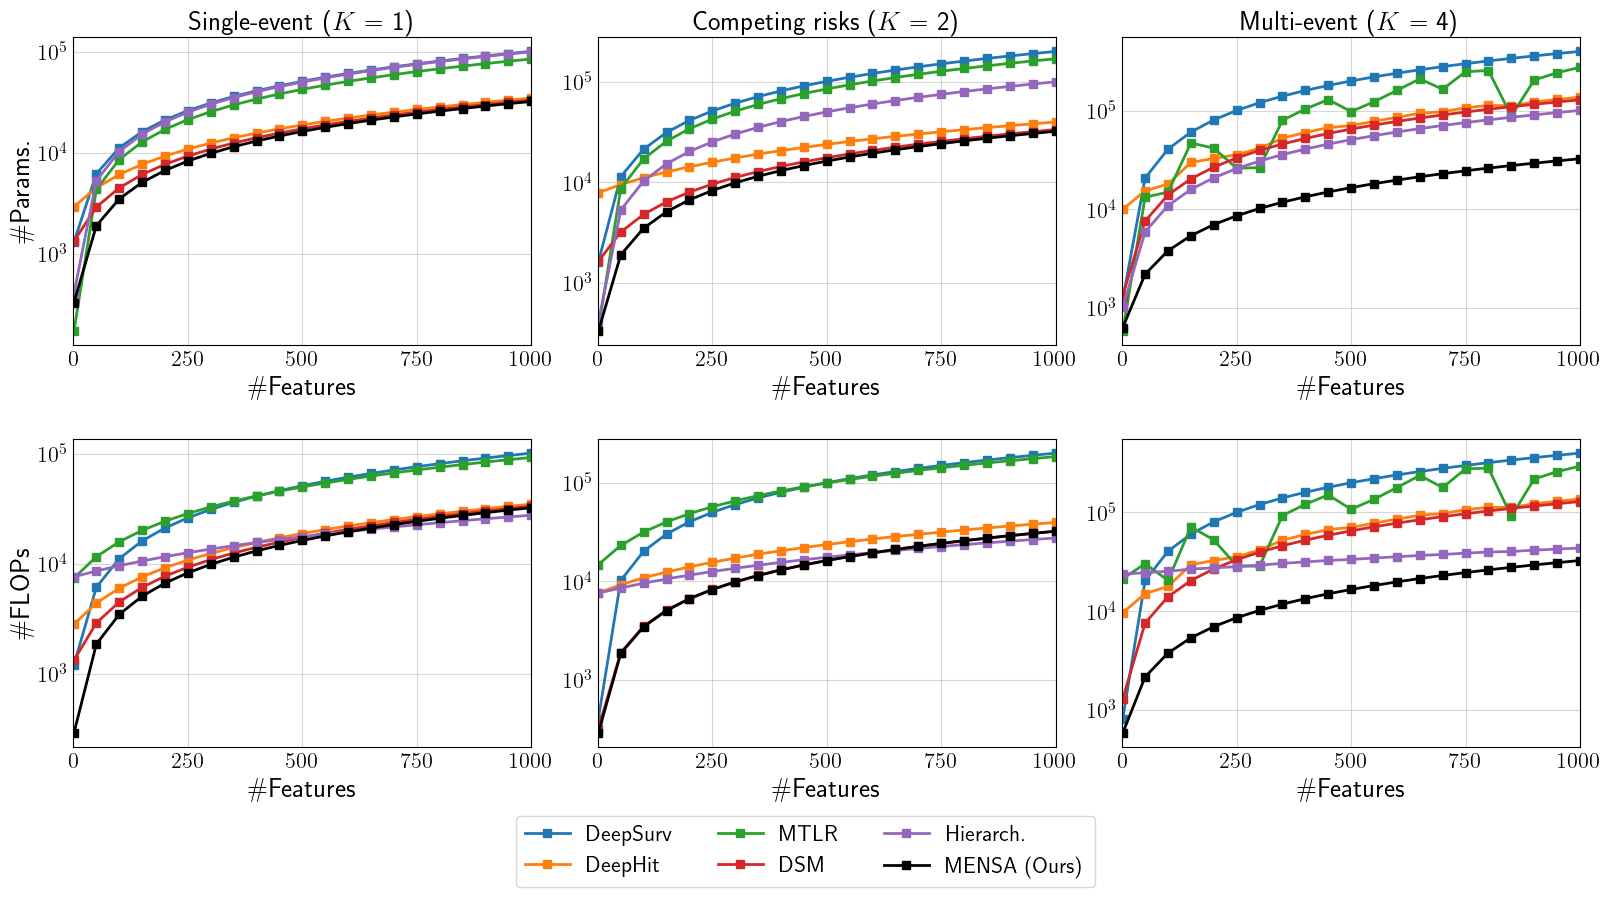

In [2]:
model_names = ["DeepSurv", "DeepHit", "MTLR", "DSM", "Hierarch.", "MENSA (Ours)"]
subplot_cases = ['Single-event', 'Competing risks', 'Multi-event']

fig, axs = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True,
                        gridspec_kw={'hspace': 0.1})

handles = []
labels = []

for row in range(2):
    for col, case in enumerate(subplot_cases):
        ax = axs[row, col]
        
        # Select the appropriate dataset
        if case == "Single-event":
            df = df_single
        elif case == 'Competing risks':
            df = df_competing
        else:
            df = df_multi
        
        for i, model_name in enumerate(model_names):
            model_data = df[df['ModelName'] == model_name]

            # Determine jitter based on case and row
            if model_name in ["DeepSurv", "DSM"] and (
                (case == "Single-event") or (row == 0 and case == "Competing risks")
            ):
                jitter = 1000
            else:
                jitter = 0

            # Select the metric to plot
            if row == 0:
                metric = model_data['SumParams'] + jitter
                ylabel = "\\#Params."
            else:
                metric = model_data['SumFlops'] + jitter
                ylabel = "\\#FLOPs"

            # Plot the data
            is_last = (model_name == "MENSA (Ours)")
            line, = ax.plot(model_data['NumFeatures'], metric,
                            color=f'C{i}' if not is_last else '#000000', alpha=1,
                            marker="s", label=model_name,
                            linewidth=2, markersize=6)
            
            if model_name not in labels:
                handles.append(line)
                labels.append(model_name)

        # Set y-axis to log scale
        ax.set_yscale('log')

        # Set x-axis range and ticks
        ax.set_xlim(1, 1000)
        ax.set_xticks(np.arange(0, 1001, 250))
        ax.set_xlabel("\\#Features")

        # Add column headings only for the first row
        if row == 0:
            if col == 0:
                case += " (" + r'$K$ = 1' + ")"
            elif col == 1:
                case += " (" + r'$K$ = 2' + ")"
            else:
                case += " (" + r'$K$ = 4' + ")"
            ax.set_title(case)

        ax.grid(True, alpha=0.5)

        if col == 0:  # Add Y-label only on the leftmost column
            ax.set_ylabel(ylabel)
        
        ax.tick_params(axis='y', which='both', length=0)
        ax.tick_params(axis='x', which='both', length=0)

# Add a single legend for all subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)
fig.savefig(f"{cfg.PLOTS_DIR}/model_complexcity.pdf", format='pdf', bbox_inches='tight')

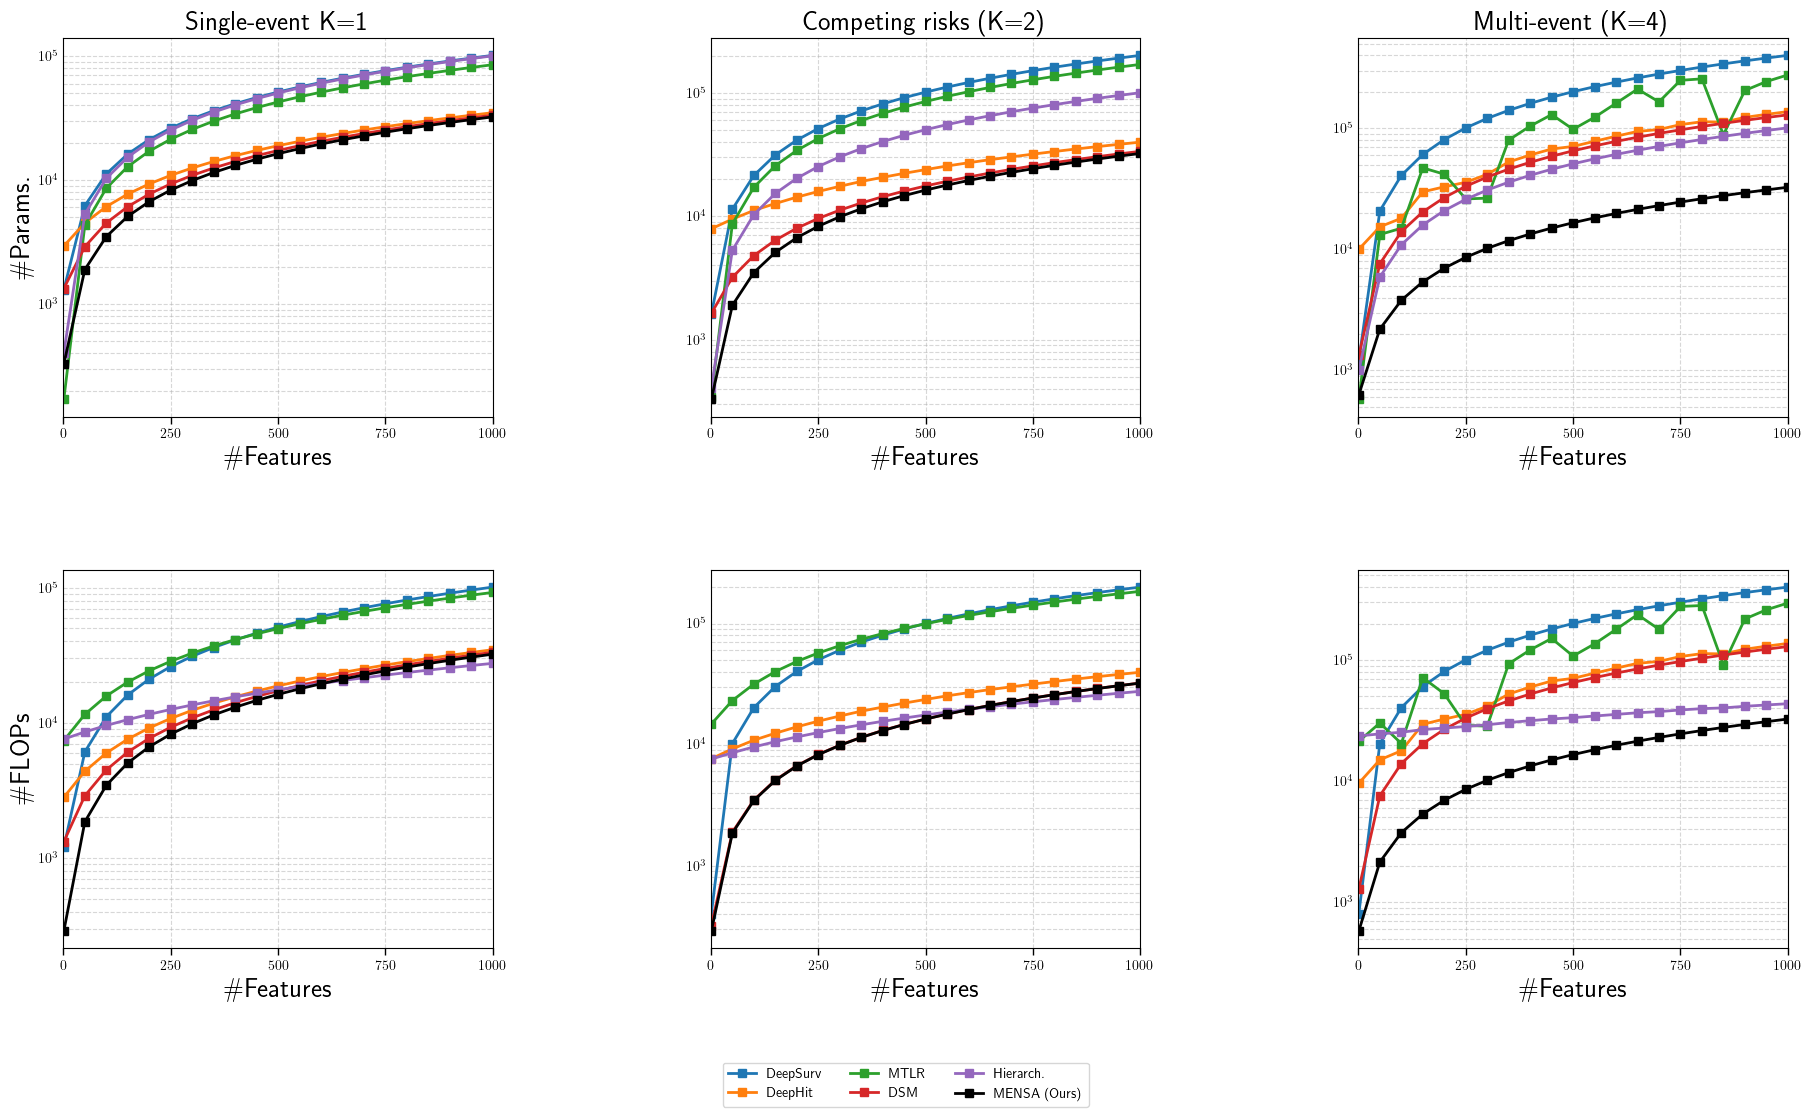

In [3]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ["DeepSurv", "DeepHit", "MTLR", "DSM", "Hierarch.", "MENSA (Ours)"]
subplot_cases = ['Single-event', 'Competing risks', 'Multi-event']

fig, axs = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': 0.3})

handles = []
labels = []

# Define color palette
colors = plt.cm.tab10.colors  # Using a predefined color palette

for row in range(2):
    for col, case in enumerate(subplot_cases):
        ax = axs[row, col]

        # Select the appropriate dataset
        if case == "Single-event":
            df = df_single
        elif case == 'Competing risks':
            df = df_competing
        else:
            df = df_multi

        for i, model_name in enumerate(model_names):
            model_data = df[df['ModelName'] == model_name]

            # Determine jitter based on case and row
            jitter = 0
            if model_name in ["DeepSurv", "DSM"] and ((case == "Single-event") or (row == 0 and case == "Competing risks")):
                jitter = 1000

            # Select the metric to plot
            if row == 0:
                metric = model_data['SumParams'] + jitter
                ylabel = "\\#Params."
            else:
                metric = model_data['SumFlops'] + jitter
                ylabel = "\\#FLOPs"

            # Plot the data
            is_last = (model_name == "MENSA (Ours)")
            line, = ax.plot(model_data['NumFeatures'], metric,
                            color=colors[i] if not is_last else '#000000', alpha=1,
                            marker="s", label=model_name,
                            linewidth=2, markersize=6)
            
            if model_name not in labels:
                handles.append(line)
                labels.append(model_name)

        # Set y-axis to log scale
        ax.set_yscale('log')

        # Set x-axis range and ticks
        ax.set_xlim(1, 1000)
        ax.set_xticks(np.arange(0, 1001, 250))
        ax.set_xlabel("\\#Features")

        # Add column headings only for the first row
        if row == 0:
            if col == 0:
                ax.set_title(f"{case} K=1")
            elif col == 1:
                ax.set_title(f"{case} (K=2)")
            else:
                ax.set_title(f"{case} (K=4)")

        ax.grid(True, which='both', axis='both', linestyle='--', alpha=0.5)

        # Add Y-label only on the leftmost column
        if col == 0:
            ax.set_ylabel(ylabel)

        # Adjust tick parameters for better readability
        ax.tick_params(axis='both', which='both', length=5, width=1, labelsize=10)
        ax.tick_params(axis='y', which='both', length=0)

# Add a single legend for all subplots at the bottom
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=10)